This notebook makes use of the ARIMA model to forecast the price of cryptocurrency pairs using data found on Binance.

To make use of it:
- select the pair you want to study in the next cell
- add a .env file containing your binance API_KEY and SECRET_KEY, like so:

API_KEY = "key goes here"
SECRET_KEY = "key goes here"

In [164]:
#Define the pair you want to study, has to be available on binance, matches the name of the CSV that is loaded

pair = 'ARBUSDT'

In [165]:
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import pmdarima as pm
from dotenv import load_dotenv
import os

In [166]:
#Try to connect to Binance to get up to date data, if not, runs with local data in CSV

def getData(ticker, interval):
    Client.KLINE_INTERVAL_1DAY
    klines = client.get_historical_klines(ticker, interval, "1 Jan, 2014")

    data = pd.DataFrame(klines)
    data.columns = ['open_time','open', 'high', 'low', 'close',
                     'volume','close_time', 'qav','num_trades','taker_base_vol',
                     'taker_quote_vol', 'ignore']
    
    data.index = [dt.datetime.fromtimestamp(x/1000.0) for x in data.close_time] # type: ignore

    data.to_csv('data/'+ticker+'.csv', header=True)
    df=data.astype(float)
    return df

if 'SECRET_KEY' in os.environ and 'API_KEY' in os.environ:
    load_dotenv()
    apiKey = os.getenv('API_KEY')
    secretKey = os.getenv('SECRET_KEY')
    client = Client(apiKey, secretKey)
    df = getData(pair, '1d')
else:
    df = pd.read_csv('data/'+pair+'.csv', index_col=0)
    print("FAIL")

In [167]:
df.head()

,open_time,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
2023-03-24 07:59:59.999,1.679530e+12,0.5000,1.6000,0.5000,1.3217,495714259.2,1.679616e+12,6.699321e+08,1554607.0,239582225.3,3.242327e+08,0.0
2023-03-25 07:59:59.999,1.679616e+12,1.3218,1.5675,1.1717,1.2727,543509688.1,1.679702e+12,7.525238e+08,1454212.0,256537764.5,3.561225e+08,0.0
2023-03-26 07:59:59.999,1.679702e+12,1.2726,1.3150,1.1800,1.2178,281919109.5,1.679789e+12,3.495201e+08,594751.0,132853921.8,1.648527e+08,0.0
2023-03-27 07:59:59.999,1.679789e+12,1.2179,1.3499,1.2021,1.2818,242122030.3,1.679875e+12,3.101857e+08,450244.0,121101774.6,1.551846e+08,0.0
2023-03-28 07:59:59.999,1.679875e+12,1.2818,1.3259,1.1160,1.1657,255551499.3,1.679962e+12,3.116048e+08,478861.0,116410350.0,1.423288e+08,0.0


In [168]:
prices = pd.DataFrame({'close': df['close']})
prices.head()

,close
2023-03-24 07:59:59.999,1.3217
2023-03-25 07:59:59.999,1.2727
2023-03-26 07:59:59.999,1.2178
2023-03-27 07:59:59.999,1.2818
2023-03-28 07:59:59.999,1.1657


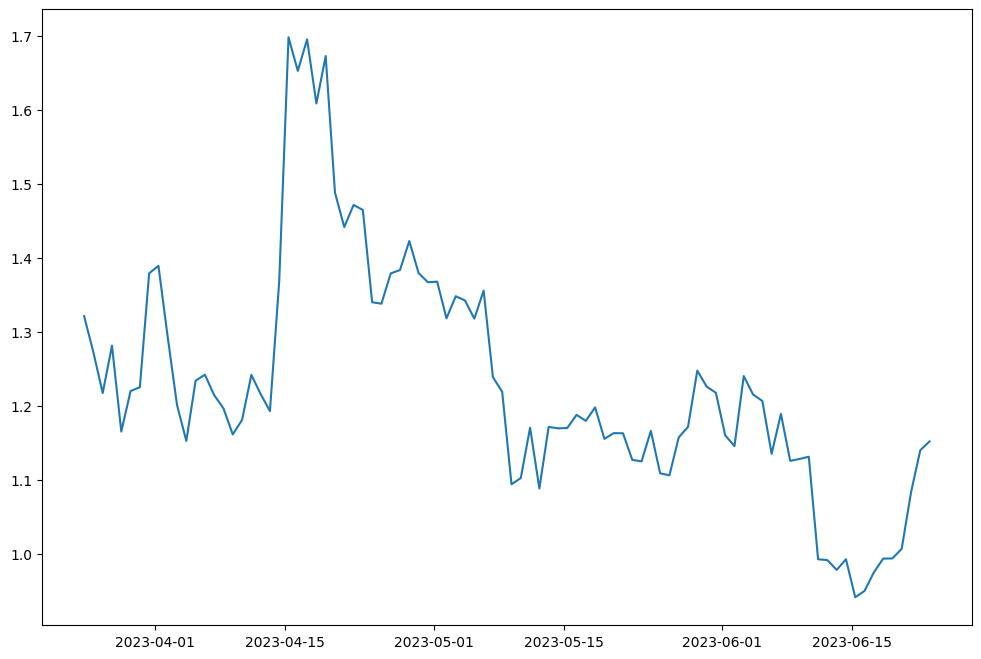

In [169]:
def graph_price(target_series):
    fig, ax = plt.subplots(figsize=(12,8), dpi=100)
    ax.plot(target_series['close'])

graph_price(prices)

ARIMA is used for stationnary series.
Ours is not stationnary so we'll employ a few tricks like playing with the variance to make a pattern appear.

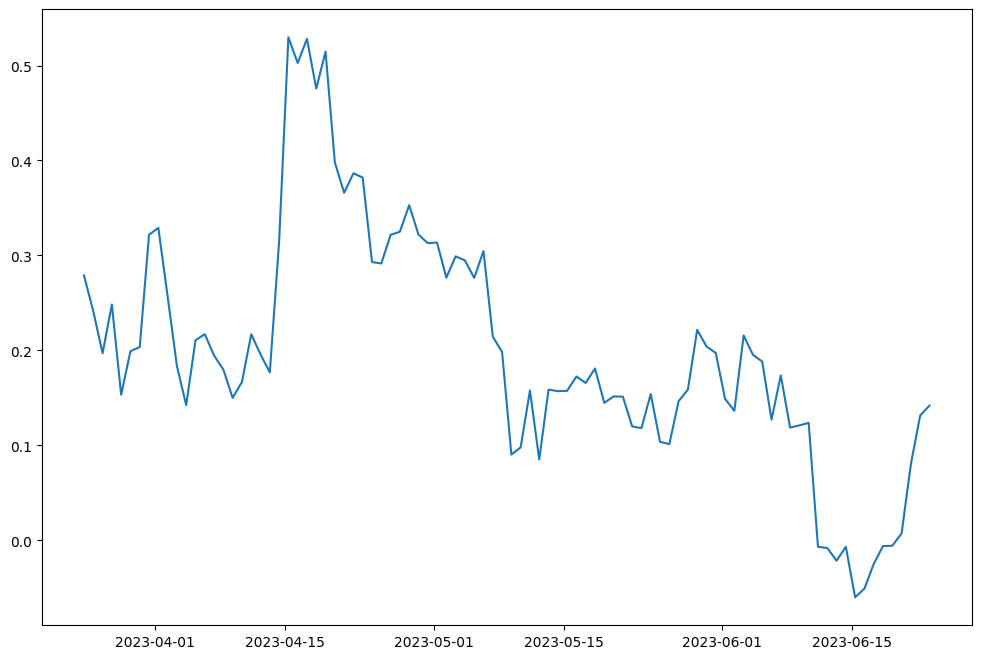

In [170]:
#Reducing the variance: let's

prices['close'] = np.log(prices['close'])

fig, ax = plt.subplots(figsize=(12,8), dpi=100)
ax.plot(prices['close'])

Better but still clearly not stationnary. We'll do some more modifications.

We can use two different tests to check wether or not a time series is stationnary:
- The Augmented Dicky Fuller Test (ADF Test): Is used to test the null hypothesis that the series is non-stationary. The more negative the number is, the more prominent the rejection of the null hypothesis that the time series is non-stationary. Further, if the p-value is < 0.05, we can reject the null hypothesis.

- The Kwiatkowski–Phillips–Schmidt–Shin (KPSS): Is used to test the null hypothesis that the series is stationary. The higher the test statistic, the more prominent the rejection of the null hypothesis that the series is stationary. Further, if the p-value is < 0.05, we can reject the null hypothesis.

In [171]:
def adf_test(target_series):
    result = adfuller(target_series)
    adf_statistics= result[0]
    p_value = result[1]
    print("ADF Statistics: %f" % adf_statistics)
    print("p-value: %f" %p_value)
    return adf_statistics, p_value

def kpss_test(target_series):
    print("Results of Kpss test:")
    kpsstest = kpss(target_series, regression='ct', nlags='auto')
    kpss_output = pd.Series(
        kpsstest[0:3], index = ["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" %key] = value
    print(kpss_output)

adf_statistic, p_value = adf_test(prices['close'])
kpss_test(prices['close'])

ADF Statistics: -2.010119
p-value: 0.282154
Results of Kpss test:
Test Statistic           0.158961
p-value                  0.039199
Lags Used                5.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64


In [172]:
#Let's differenciate the time series to get the returns per 4h time frame

prices['close'] = prices['close'].diff()
prices.dropna(inplace = True)

In [173]:
#Let's check to see if that made a difference

adf_statistic, p_value = adf_test(prices['close'])
kpss_test(prices['close'])


ADF Statistics: -9.506024
p-value: 0.000000
Results of Kpss test:
Test Statistic           0.047807
p-value                  0.100000
Lags Used                0.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64


/var/folders/8y/w13bxlj534g002y4ctp0nqq40000gn/T/ipykernel_48282/25856268.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(target_series, regression='ct', nlags='auto')


Null hypothesis has been rejected for the ADF, whereas the null hypothesis cannot be rejected for the KPSS, which suggests the time series is now stationary.

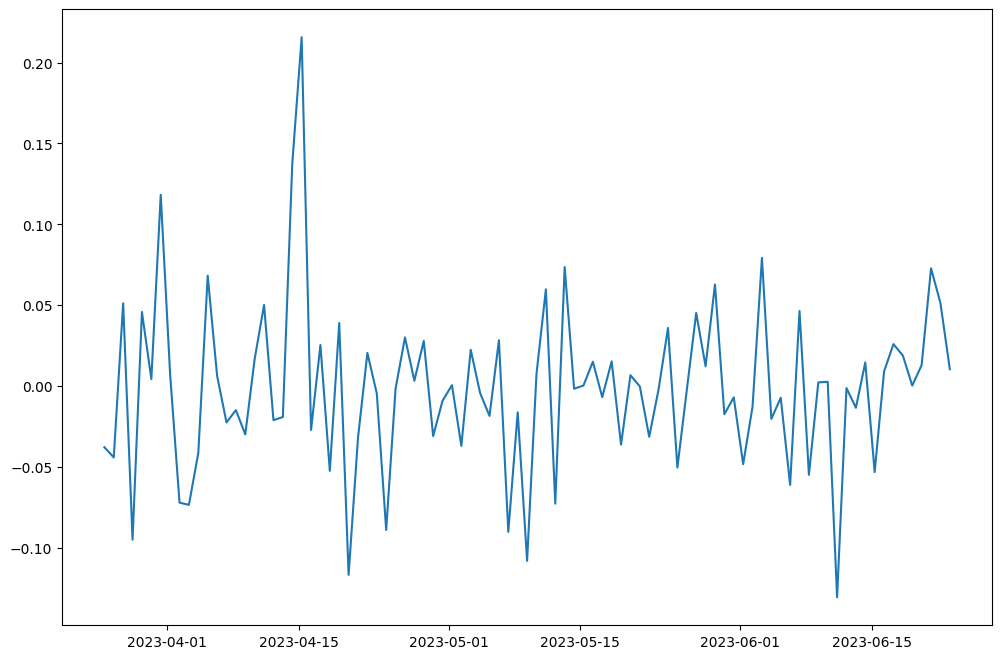

In [174]:
#Returns have a constant mean and constant variance

graph_price(prices)

---------------------- Computing the values of the model --------------------------

At this point we have a stationnary time series, we can dive into the ARIMA model 

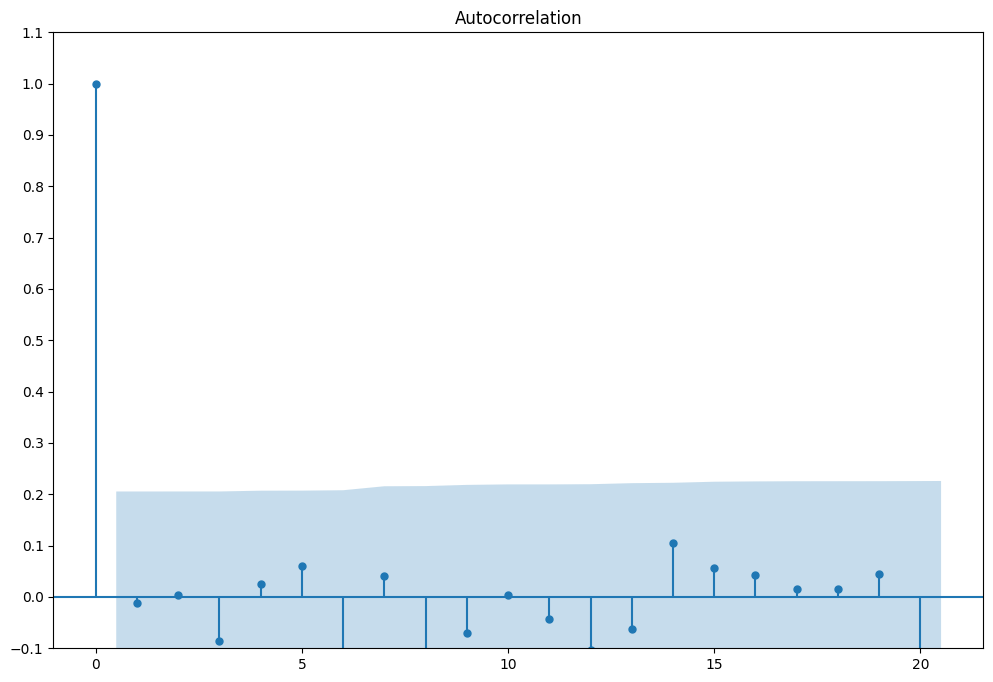

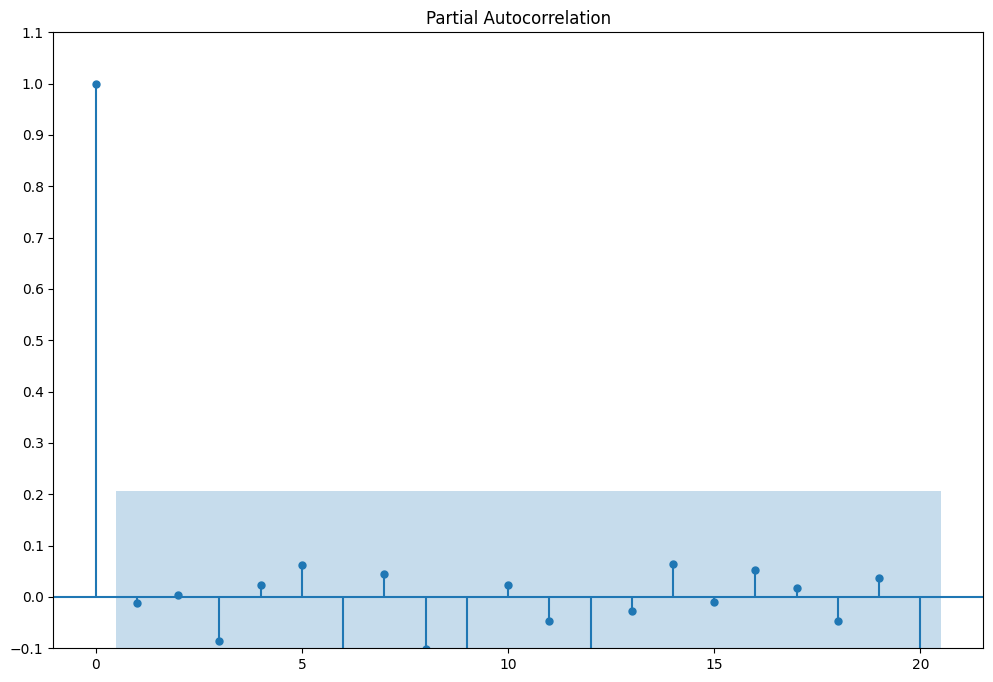

In [175]:
#Let's now find the values for AR and MA

#One way we can obtain the terms is using statsmodels Auto Correlation Function (ACF) and Partial Auto Correlation Function (PACF) plot functions.

#ACF
fig, ax = plt.subplots(1, figsize=(12,8), dpi=100)
plot_acf(prices['close'], lags=20, ax = ax)
plt.ylim([-0.05, 0.25])
plt.yticks(np.arange(-0.1, 1.1, 0.1))
plt.show()

#PACF
fig, ax = plt.subplots(1, figsize=(12,8), dpi=100)
plot_pacf(prices['close'], lags=20, ax = ax)
plt.ylim([-0.05, 0.25])
plt.yticks(np.arange(-0.1, 1.1, 0.1))
plt.show()

#When observing both these plots, we look for significant points outside the shaded area and a geometric decay if we are dealing with a times series where ARIMA may be appropriate.

Although there are some significant points, there is no geometric decay, and there is a sharp drop off after lag 0.
Defining the model’s terms by using these charts is complex and would be prone to error, and it is relatively likely what we are seeing is an ARIMA(0, 1, 0) model, but we may be fooled into thinking we have any combination of 6 and 10 for our AR and MA terms. If we are indeed dealing with an ARIMA(0, 1, 0) model, our differenced data will be what is known as “white noise” and will mean our original data is what is known as a “random walk”. Before moving forward, it is essential to discuss these two concepts.

So we now have a few issues:

- We need to know if our time series is a random walk.
- We need to know what our order terms are for the model.

We can do these steps in unison. 
If we split the data down the middle, we can see that the mean and standard deviations are almost identical; however, the distribution of values is slightly different.

In [176]:
first_half = int(len(prices)/2)
print("First half of prices")
print(prices['close'][first_half:].describe())
print("Second half of prices")
print(prices['close'][:first_half].describe())

First half of prices
count    46.000000
mean     -0.001227
std       0.043939
min      -0.130544
25%      -0.016381
50%       0.000322
75%       0.015251
max       0.079311
Name: close, dtype: float64
Second half of prices
count    45.000000
mean     -0.001790
std       0.060564
min      -0.116708
25%      -0.031939
50%      -0.004562
75%       0.025443
max       0.215665
Name: close, dtype: float64


<Axes: >

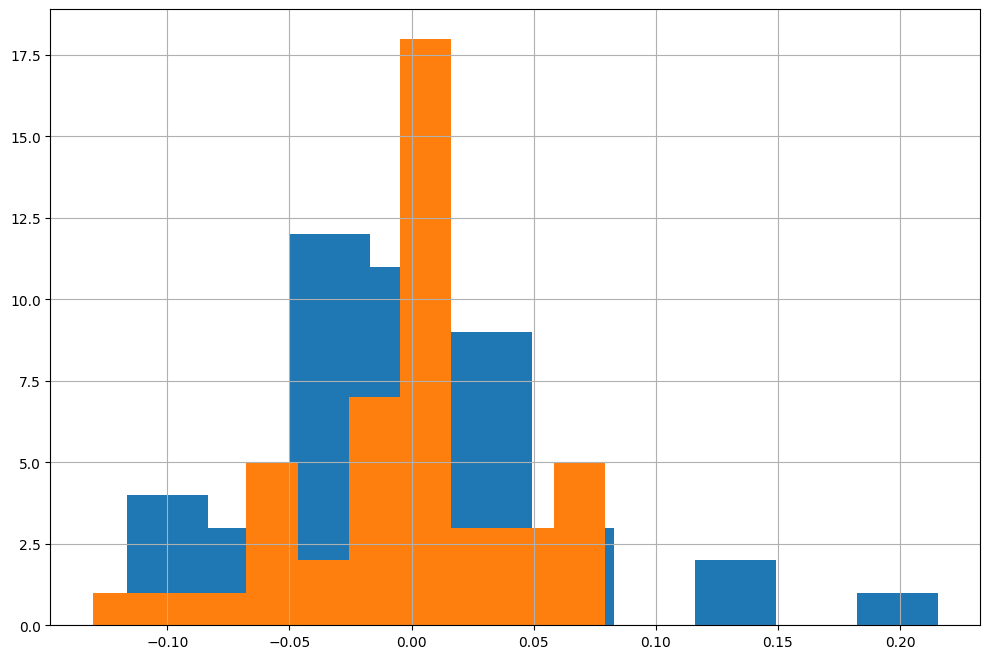

In [177]:
fig, ax = plt.subplots(1, figsize=(12,8), dpi=100)
prices['close'][:first_half].hist()
prices['close'][first_half:].hist()

We can use the Ljung–Box test, which determines whether any group of autocorrelations in a time series differs from zero. 

The test can be defined as :

- H0: The data is distributed independently.
- Ha: The data is not distributed randomly; instead, they exhibit serial correlation.

The test can be applied to our data and our fitted model’s residuals. If the null hypothesis is rejected, we have statistical evidence that the data contains serial correlation and is not white noise. On the other hand, when we apply the test to our model’s residuals, a well-fitted model should return statistical evidence that the residuals are white noise as this would imply our model has captured all the correlated aspects within the data, and all that is left is noise.

In [178]:
sm.stats.acorr_ljungbox(prices['close'], lags=[20], return_df=True)

#The data is not distributed randomly and is not white noise.

,lb_stat,lb_pvalue
20,15.198134,0.76496


In [179]:
def auto_arima(original_df):
    original_df = np.log(original_df['close'])
    model = pm.auto_arima(original_df,
                          start_p=10,
                          start_q=10,
                          test='adf',
                          max_p=10,
                          max_q=10,
                          m=1,
                          d=None,
                          seasonal=False,
                          D=0,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)
    differenced_by_auto_arima = original_df.diff(model.order[1])
    return model.order, differenced_by_auto_arima, model.resid()

original_prices = pd.DataFrame({'close': df['close']})
#original_prices.index = pd.DatetimeIndex(original_prices.index).to_period('4h')
model_order, differenced_data, model_residuals = auto_arima(original_prices)

Performing stepwise search to minimize aic
 ARIMA(10,1,10)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-275.022, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-273.033, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-273.033, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-276.947, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-271.033, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.014 seconds


In [180]:
sm.stats.acorr_ljungbox(model_residuals, lags=[20], return_df=True)

#we cannot reject the null hypothesis, and our residuals are white noise.

,lb_stat,lb_pvalue
20,12.481849,0.898494


------------- Making predictions -----------------

We now have a working model and we can use it to make predictions

In [181]:
original_prices.index = pd.DatetimeIndex(original_prices.index).to_period('D')
original_prices.index = original_prices.index.to_timestamp()
pd.plotting.register_matplotlib_converters()

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


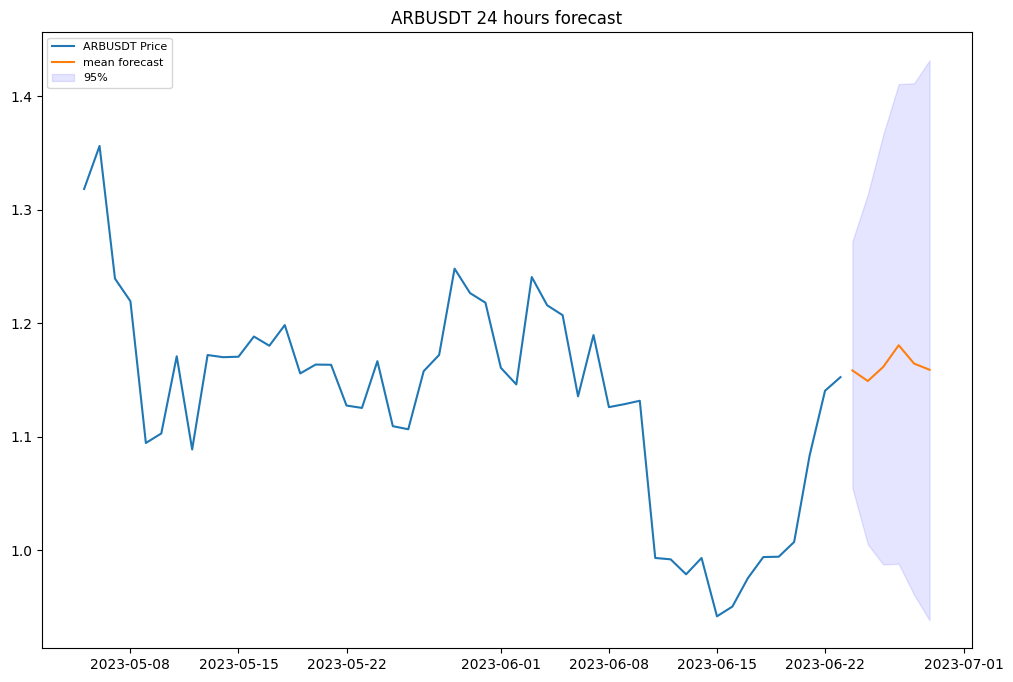

In [182]:
model = sm.tsa.arima.ARIMA(np.log(original_prices['close']), order = (10,1,10))
fitted = model.fit()

fc = fitted.get_forecast(6)
fc = fc.summary_frame(alpha=0.05)
fc_mean = fc['mean']
fc_lower = fc['mean_ci_lower']
fc_upper = fc['mean_ci_upper']

plt.figure(figsize=(12,8), dpi=100)
plt.plot(original_prices['close'][-50:], label= pair+' Price')

future_24h = [dt.datetime.today() + dt.timedelta(days=x) for x in range(1,7)]
plt.plot(future_24h, np.exp(fc_mean), label='mean forecast', linewidth=1.5)

plt.fill_between(future_24h, np.exp(fc_lower), np.exp(fc_upper), color='b', alpha=.1, label= '95%')

plt.title(pair+" 24 hours forecast")

plt.legend(loc='upper left', fontsize=8)
plt.show()

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


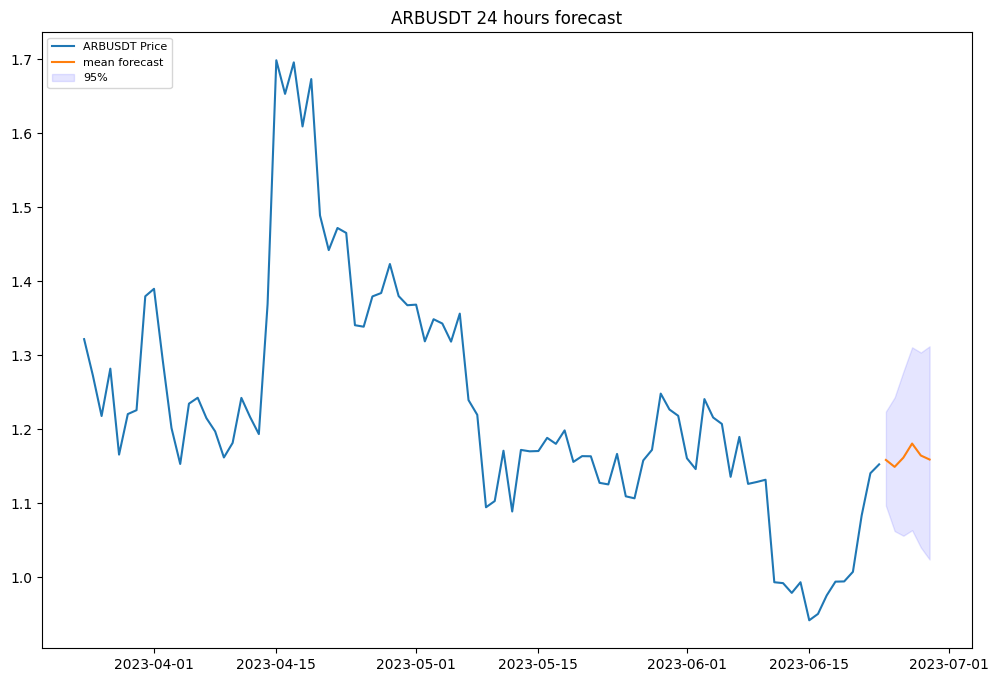

In [183]:
model = sm.tsa.arima.ARIMA(np.log(original_prices['close']), order = (10,1,10))
fitted = model.fit()

fc = fitted.get_forecast(6)
fc = fc.summary_frame(alpha=0.25)
fc_mean = fc['mean']
fc_lower = fc['mean_ci_lower']
fc_upper = fc['mean_ci_upper']

plt.figure(figsize=(12,8), dpi=100)
plt.plot(original_prices['close'][-1000:], label=pair+' Price')

future_24h = [dt.datetime.today() + dt.timedelta(days=x) for x in range(1,7)]
plt.plot(future_24h, np.exp(fc_mean), label='mean forecast', linewidth=1.5)

plt.fill_between(future_24h, np.exp(fc_lower), np.exp(fc_upper), color='b', alpha=.1, label= '95%')

plt.title(pair+" 24 hours forecast")

plt.legend(loc='upper left', fontsize=8)
plt.show()